In [1]:
!wget andrewnomy.com/sync/MC_C_20211225_002780_R13_S11.fits

--2022-07-27 21:18:49--  http://andrewnomy.com/sync/MC_C_20211225_002780_R13_S11.fits
Resolving andrewnomy.com (andrewnomy.com)... 72.14.187.205
Connecting to andrewnomy.com (andrewnomy.com)|72.14.187.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881600 (13M) [text/plain]
Saving to: ‘MC_C_20211225_002780_R13_S11.fits’

MC_C_20211225_00278 100%[===================>]  13.24M  13.2MB/s    in 1.0s    

2022-07-27 21:18:50 (13.2 MB/s) - ‘MC_C_20211225_002780_R13_S11.fits’ saved [13881600/13881600]



In [2]:
import numpy as np
from astropy.io import fits
import time,glob,sys
from astropy import stats
from copy import deepcopy as dcopy
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel


def mosaic_combine(filename,gainlist=[1.]*16,nsig=3,niter=5,cenfunc='mean',grow=False,blursig=2,
                   do_xy_overscan=True,do_y_overscan=True,do_x_overscan=True,
                   yoscanplus=2,xoscanplus=2):
    "Takes in a multi-extension mosaic fits file and the dimensions of the mosaic and returns an array with all chips combined"
    hdr0 = fits.getheader(filename,1)
    xmin,xmax,ymin,ymax=np.array(hdr0['DATASEC'].strip('[').strip(']').replace(':',',').split(','),dtype=int)
    xs,ys=hdr0['NAXIS1'],hdr0['NAXIS2']
    px,py=xmin-1,ymin-1
    ox,oy=xs-px-xmax-1,ys-py-ymax-1
    xs,ys=xmax-xmin+1,ymax-ymin+1
    #print(xs,ys,px,py,ox,oy)
    ccdarray = np.zeros((ys*2,xs*8),dtype='float')
        
    for ampnum in range(16):
        ccdseg = fits.getdata(filename,ampnum+1).astype('float')
        if do_xy_overscan:
            oxyfoo=ccdseg[-oy+yoscanplus:,-ox+xoscanplus:]#
            #oxyfoo=snd.gaussian_filter(ccdseg[-oy:,-ox:],sigma=blursig,mode='nearest')#spatial
            oxymean,oxymed,oxystd=stats.sigma_clipped_stats(oxyfoo,sigma=nsig,maxiters=niter,cenfunc=cenfunc,grow=grow)
            ccdseg-=oxymean
        if do_y_overscan:
            oyfoo=ccdseg[-oy+yoscanplus:,:]
            oymean,oymed,oystd=stats.sigma_clipped_stats(oyfoo,axis=0,sigma=nsig,maxiters=niter,cenfunc=cenfunc,grow=grow)
            ccdseg-=oymean
        if do_x_overscan:
            oxfoo=ccdseg[:,-ox+xoscanplus:]
            oxmean,oxmed,oxstd=stats.sigma_clipped_stats(oxfoo,axis=1,sigma=nsig,maxiters=niter,cenfunc=cenfunc,grow=grow)
            ccdseg=(ccdseg.T-oxmean).T
        
        ccdseg=ccdseg[py:py+ys,px:px+xs]
        hdr = fits.getheader(filename,ampnum+1)
        seggain=gainlist[ampnum]
        ccdseg*=seggain
        detsec = hdr['DETSEC'].strip("[']").split(",")
        x1 = int(detsec[0].strip("'").split(":")[0])
        x2 = int(detsec[0].strip("'").split(":")[1])
        y1 = int(detsec[1].strip("'").split(":")[0]) 
        y2 = int(detsec[1].strip("'").split(":")[1])
        # x1, x2, y1, y2 are the extents of each segment
        ltm11 = hdr['DTM1_1']
        
        ltm22 = hdr['DTM2_2']
        # LTM1_1 and LTM2_2 are +/-1 and tell whether the direction is inverted 
        if ltm22 < 0:
            y1,y2 = y2,y1
            ccdseg=ccdseg[::-1,:]
        y1, x1 = y1 - 1, xs* 8 - x1
        x2 = xs * 8 - x2
        if ltm11 > 0:
            x1,x2 = x2,x1
            ccdseg=ccdseg[:,::-1]
        x2 = x2 + 1
        #print(y1,y2,x1,x2)
        ccdarray[y1:y2,x1:x2]=ccdseg
    # The code here keeps the convention of having 0,0 in the lower left.
    # This is different from ds9, which has 0,0 in the lower right.
    return ccdarray[:,::-1]

def imshowdatclip(dat,titlefoo='scaled image',nstdim=3,nstdhist=10,nbins=100,lineplotsymlog=True,ev=1,vminmaxim=(np.NaN,np.NaN),vminlog=-1e5,vmaxlog=1e5,
                  lineplotxvals=[500,1500,2500,3500],lineplotyvals=[500,1500,2500,3500],
                  lineplotxminmax=(np.NaN,np.NaN),lineplotyminmax=(np.NaN,np.NaN),lineplotlinthreshy=50):
    if ev>1: datfoo=dat.copy()[::ev,::ev]
    else: datfoo=dat
    mean,med,std=stats.sigma_clipped_stats(datfoo[~np.isnan(datfoo)])
    minfoo,maxfoo=np.min(datfoo),np.max(datfoo)
    vminim,vmaxim=mean-nstdim*std,mean+nstdim*std
    
    print(vminim,vmaxim,mean,med,std)
    
    fig0=plt.figure(figsize=(22,10))
    for jj,yval in enumerate(lineplotyvals):
        plt.subplot(122)
        p=plt.plot(datfoo[int(yval/ev),:],label=str(yval),linewidth=3,alpha=.8)
        plt.subplot(121),plt.axhline(yval,c=p[0].get_color(),alpha=.8,ls='--',linewidth=3)#
    plt.subplot(122),plt.legend()
    if lineplotsymlog: plt.yscale('symlog',linthresh=lineplotlinthreshy)
    if lineplotyminmax != (np.NaN,np.NaN): plt.ylim(lineplotyminmax)
    if lineplotxminmax != (np.NaN,np.NaN): plt.xlim(lineplotxminmax)

    plt.subplot(121)
    if vminmaxim != (np.NaN,np.NaN): vminim,vmaxim=vminmaxim
    plt.imshow(datfoo,vmin=vminim,vmax=vmaxim,cmap=plt.cm.Greys_r,origin='lower'),plt.colorbar()
    plt.title('(vmin, vmax, range, nstd)\n'+str(round(vminim,5))+', '+str(round(vmaxim,5))+', '+
              str(round(vmaxim-vminim,5))+', '+str(nstdim))
    plt.suptitle(titlefoo)
    
    return mean,med,std,fig0

In [3]:
sensnum='R13_S11'#R20_S11,R32_S11,R13_S11,R41_S11
rawdir='/home/andrew/notebooks/'
#rawdir='/sdf/group/lsst/camera/IandT/rawData/focal-plane/2021122[5,6]/*/' #streakmas# 20211220/*/ #spotmas

fitslist=np.sort(glob.glob(rawdir+'*'+sensnum+'.fits'))
nfits=len(fitslist)
print(nfits,"files \n",fitslist[:2],fitslist[int(nfits/2)],fitslist[-2:])

1 files 
 ['/home/andrew/notebooks/MC_C_20211225_002780_R13_S11.fits'] /home/andrew/notebooks/MC_C_20211225_002780_R13_S11.fits ['/home/andrew/notebooks/MC_C_20211225_002780_R13_S11.fits']


-11.135893151740808 13.06299704640339 0.9635519473312911 0.8845042271020718 4.033148366357366


(0.9635519473312911,
 0.8845042271020718,
 4.033148366357366,
 <Figure size 1584x720 with 3 Axes>)

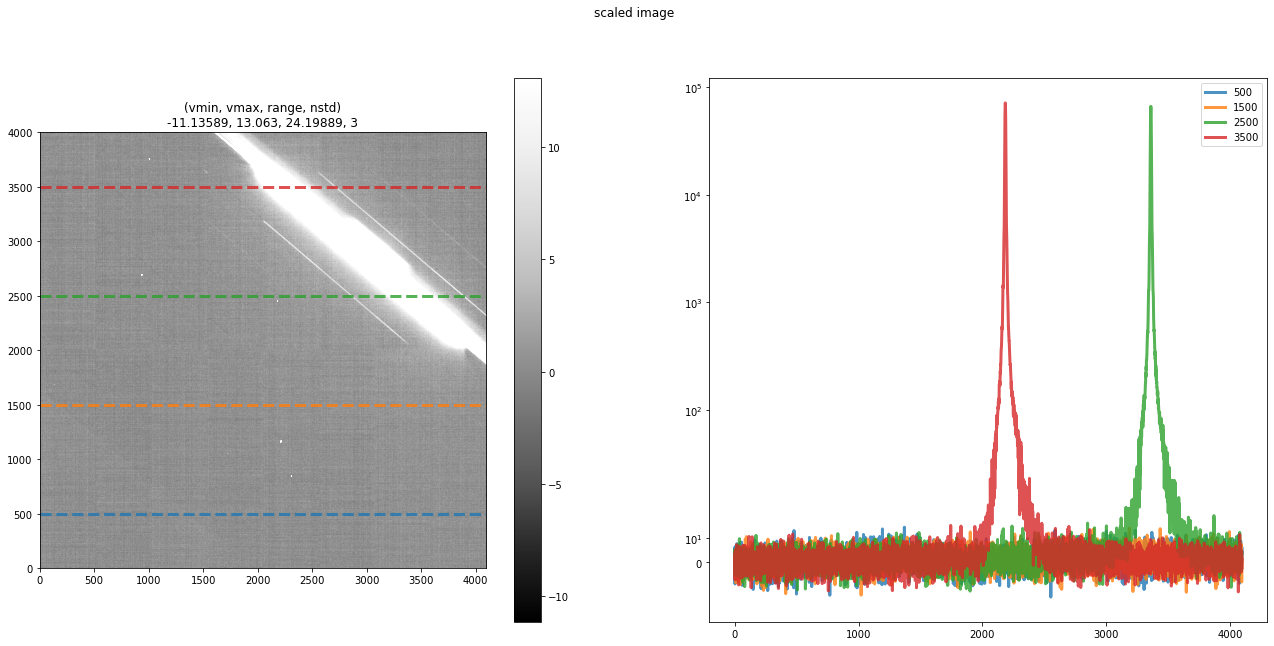

In [4]:
fitsname=fitslist[0]
mos=mosaic_combine(fitsname,do_x_overscan=True,do_y_overscan=True,do_xy_overscan=True)
imshowdatclip(mos)

In [5]:
# description of the line filter code
def streak_by_line_filter(xtalkim,minstreakpixval=1e5,ykern=np.ones(200),evrow=1,yvals=[-1],xtalkpad=10,polyfitdeg=4):
    ys,xs=xtalkim.shape
    if yvals[0]==-1: yvals=np.arange(0,ys,1)
    ymid=int(ys/2)
    ykernsz2=int(np.floor(len(ykern)/2))
    iore=1
    if ys==4004: iore=-1 # e2v or itl midline flip hack
    yas,xas=ys/2,xs/8
    maxbgpixval=minstreakpixval/2.  #the max pixel value to consider for modeling bg
    xfoo=np.arange(xs).astype('int')
    
    maskpix=np.where(xtalkim>minstreakpixval)
    bgmodel=xtalkim.copy()
    #bgerror=np.sqrt(np.abs(xtalkim))
    bgmodel[maskpix]=np.NaN
    sourcepix=xtalkim.copy()
    sourcepix[:,:]=np.NaN
    sourceamp=sourcepix.copy()
    bgerror=sourceamp.copy()
    ampnums=make_ampnum_arr(xtalkim)
    srcampvals,targampvals,xposvals,yposvals,srcvals,targvals,bgvals,bgerrvals=[],[],[],[],[],[],[],[]
    for yval in yvals:
        yval0=dcopy(yval)
        print(yval,end='\x1b\r')
        gxpix=np.where(xtalkim[yval,:]>minstreakpixval)[0]
        nxpix=len(gxpix)
        if nxpix<1: continue
        #print(gxpix)
        for i in range(-8,8):
            xshift=i*xas
            for side in ['bot','top']:
                if side=='bot':
                    yval=yval0
                    xshifted=gxpix+xshift
                if side=='top':
                    yval=ys-yval0-1
                    if iore==-1: 
                        xshifted=xs-gxpix-xshift
                    
                gxpos=np.where((xshifted>0) & (xshifted<xs))[0]
                nxpos=len(gxpos)
                if nxpos<1: continue
                xpos=xshifted[gxpos].astype('int')
                xpos0=gxpix[gxpos].astype('int')
                gxtalk_x=np.where(xtalkim[yval0,xpos0]>minstreakpixval)[0].astype('int')
                nxtalk_x=len(gxtalk_x)
                if nxtalk_x<1: continue
                #print(side,yval,gxtalk_x)
                xshifted=xshifted[gxpos][gxtalk_x].astype('int')
                xunshifted=gxpix[gxpos][gxtalk_x].astype('int')
                for xi,xval0 in zip(xshifted,xunshifted):
                    gxtalk_y=np.where((xtalkim[:,xval0]<maxbgpixval) & 
                                      (xtalkim[:,xi]<minstreakpixval))[0].astype('int')
                    ydist=np.array(yval-gxtalk_y).astype('int')
                    ydistabs=np.abs(ydist)
                    gyvals=np.where((ydistabs<ykernsz2) & (ydistabs>xtalkpad))[0].astype('int')
                    nyvals=len(gyvals)
                    if nyvals<10: continue
                    yvals=gxtalk_y[gyvals].astype('int')
                    ypixvals=xtalkim[yvals,xi] #maybe filter based upon distribution
                    
                    #estimate the errors and weights
                    ypixerrs=np.sqrt(np.abs(ypixvals))+8.1811818 #not true, but also not 0....
                    ypixwts=ykern[ydist[gyvals]]/ypixerrs
                    ypixwts/=np.sum(ypixwts)
                    p, cov = np.polyfit(yvals, ypixvals, deg=polyfitdeg, w=ypixwts, cov=True)
                    ypixvalest=np.polyval(p,yval)#p[0]*yval**3+p[1]*yval**2+p[2]*yval+p[3]
                    ypixvalerr=np.sqrt(np.sum((np.polyval(p,ypixvals)-ypixvals)**2))
                    
                    bgmodel[yval,xi]=ypixvalest
                    bgerror[yval,xi]=ypixvalerr
                    sourcepix[yval,xi]=xtalkim[yval0,xval0]
                    sourceamp[yval,xi]=ampnums[yval0,xval0]
                    
                    srcampvals.append(ampnums[yval0,xval0])
                    targampvals.append(ampnums[yval,xi])
                    xposvals.append(xi)
                    yposvals.append(yval)
                    srcvals.append(xtalkim[yval0,xval0])
                    targvals.append(xtalkim[yval,xi])
                    bgvals.append(ypixvalest)
                    bgerrvals.append(ypixvalerr)
                    
                    
    ctdat=np.array([srcampvals,targampvals,xposvals,yposvals,srcvals,targvals,bgvals,bgerrvals])
    return bgmodel,bgerror,sourcepix,sourceamp,ctdat

#a function that takes in a mosaic and returns a mosaic of amp numbers 0-16
def make_ampnum_arr(foomos):
    ysfoo,xsfoo=foomos.shape
    outmos=np.empty(foomos.shape)
    yamp,xamp=int(ysfoo/2),int(xsfoo/8)
    ifoo=0
    for j in range(2):
        for i in range(8):
            y0,y1,x0,x1=yamp*j,yamp*(j+1),xamp*i,xamp*(i+1)
            outmos[y0:y1,x0:x1]=ifoo
            ifoo+=1
    return outmos
    

(<matplotlib.image.AxesImage at 0x7fe375fb4160>,
 <matplotlib.colorbar.Colorbar at 0x7fe375f312e0>)

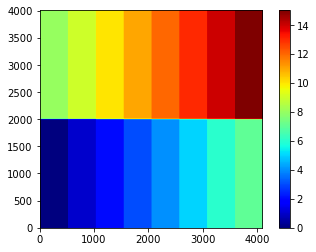

In [6]:
ampnumarr=make_ampnum_arr(mos)
plt.imshow(ampnumarr,cmap=plt.cm.jet,origin='lower'),plt.colorbar()

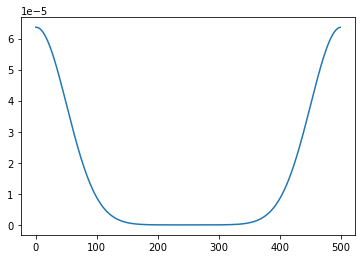

In [7]:
kernelsig=50
kernel=Gaussian2DKernel(kernelsig,x_size=500).array
midy=int(np.floor(kernel.shape[0]/2))+1
yslice=kernel[midy,:]#.roll(midy)
ykern=np.roll(yslice,shift=midy)#
plt.plot(ykern)

In [8]:
minstreakpixval=5e3
npolydeg=2
yvals=np.arange(100,3900,1)
tstart=time.time()
bgmod,bgerr,sourcepix,sourceamp,ctdat=streak_by_line_filter(mos,minstreakpixval=minstreakpixval,
                                              ykern=ykern,yvals=yvals,xtalkpad=5,polyfitdeg=npolydeg)
ttorun=time.time()-tstart
print("%.2f" % ttorun," seconds to estimate ",len(ctdat[0])," pixel data points")

256.80  seconds to estimate  455806  pixel data points


(-15.0, 100.0)

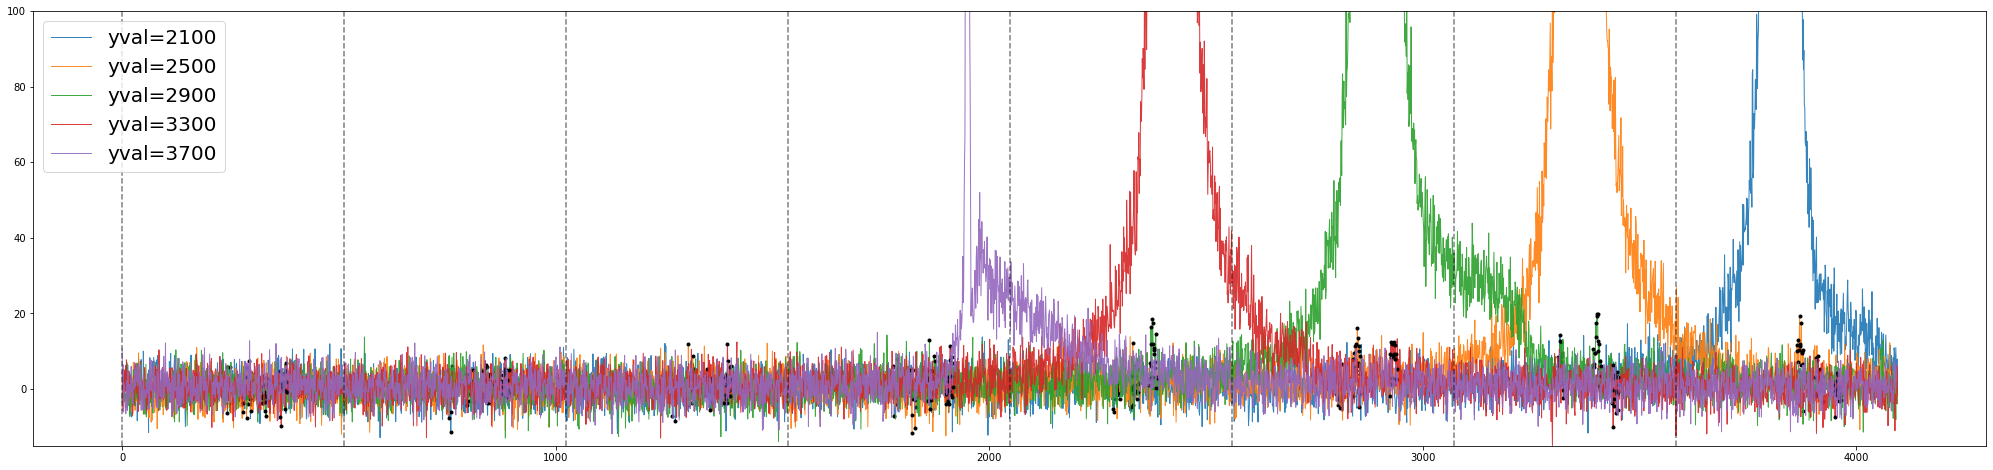

In [9]:
def crosstalk_line_plot(mos,bgmod,yval,xg):
    p0=plt.plot(mos[yval,:],linestyle='-',alpha=.9,label='yval='+str(yval),lw=1)
    plt.plot(xg,bgmod[yval,xg],'.',color=p0[0].get_color())#,label='background model')
    plt.plot(xg,mos[yval,xg],'k.')#,label='crosstalk target pixel')

plt.figure(figsize=(35,8))

for yval in yvals[2000:4000:400]:
    xg=np.where(~np.isnan(sourcepix[yval,:]))[0]
    crosstalk_line_plot(mos,bgmod,yval,xg)
plt.legend(fontsize=20,loc='upper left')

for ifoo in range(8): plt.axvline(ifoo*mos.shape[1]/8,color='k',ls='--',alpha=.5)
plt.ylim(-15,100)#,plt.xlim(250,3900)#2000,2500)#
#plt.yscale('log')

In [10]:
def median_xy(xin,yin,nxbins=100,xmin=0,xmax=25000):
    xbin=np.linspace(xmin,xmax,nxbins+1)
    ymeans=np.zeros(nxbins)
    ymeans[:]=np.NaN
    ymeds,ystds,nper=ymeans.copy(),ymeans.copy(),ymeans.copy()
    for i in range(nxbins):
        gd=np.where((xin>xbin[i]) & (xin<xbin[i+1]) & (~np.isnan(xin) & (~np.isnan(yin))))
        nper[i]=len(gd[0])
        if nper[i]<2: continue
        ymeans[i],ymeds[i],ystds[i]=stats.sigma_clipped_stats(yin[gd])
    return np.array(xbin[:-1]),ymeans,ymeds,ystds,nper

def readin_ctdats(ctdat_glob):
    srcampvals,targampvals,srcvals,targvals,bgvals,bgerrvals=[],[],[],[],[],[]
    for ctdatname in ctdat_glob:
        srcampval,targampval,xposval,yposval,srcval,targval,bgval,bgerrval=fits.getdata(ctdatname)
        srcampvals.extend(srcampval),targampvals.extend(targampval),targvals.extend(targval)
        srcvals.extend(srcval),bgvals.extend(bgval),bgerrvals.extend(bgerrval)

    srcampvals,targampvals,targvals=np.array(srcampvals),np.array(targampvals),np.array(targvals)
    srcvals,bgvals,bgerrvals=np.array(srcvals),np.array(bgvals),np.array(bgerrvals)
    return srcampvals,targampvals,targvals,srcvals,bgvals,bgerrvals

def make_binned_matrix(xin_all,yin_all,ivals,jvals,xmin0,xmax0,nxbins):
    xbins=np.zeros((16,16,nxbins))
    xbins[:,:,:]=np.NaN
    ymeans,ymeds,ystds,npers=xbins.copy(),xbins.copy(),xbins.copy(),xbins.copy()
    
    for i in range(16):
        for j in range(16):
            g=np.where((ivals==i) & (jvals==j))[0]
            xbin,ymean,ymed,ystd,nper=median_xy(xin_all[g],yin_all[g],nxbins,xmin=xmin0,xmax=xmax0)
            xbins[i,j],ymeans[i,j],ymeds[i,j],ystds[i,j],npers[i,j]=xbin,ymean,ymed,ystd,nper
    return xbins,ymeans,ymeds,ystds,npers

In [11]:
ctdatname='foo50.ctdat'
fits.writeto(ctdatname,ctdat,overwrite=True)

srcampvals_st,targampvals_st,xposvals_st,yposvals_st,srcvals_st,targvals_st,bgvals_st,bgerrvals_st=fits.getdata(ctdatname)
tstart=time.time()
#srcampvals_st,targampvals_st,targvals_st,srcvals_st,bgvals_st,bgerrvals_st=readin_ctdats(['foo50.ctdat'])
print(time.time()-tstart,len(srcampvals_st))

tstart=time.time()
xmin0,xmax0,nxbins=5e3,1.5e5,40
xbins_st,ymeans_st,ymeds_st,ystds_st,npers_st=make_binned_matrix(srcvals_st,targvals_st-bgvals_st,srcampvals_st,targampvals_st,xmin0,xmax0,nxbins)
print(time.time()-tstart)

xplot_st=xbins_st.copy()
yplot_st=(ymeds_st/xbins_st).copy()
yploterr_st=(ystds_st/xbins_st/np.sqrt(npers_st)).copy()

5.1975250244140625e-05 455806
0.5694091320037842


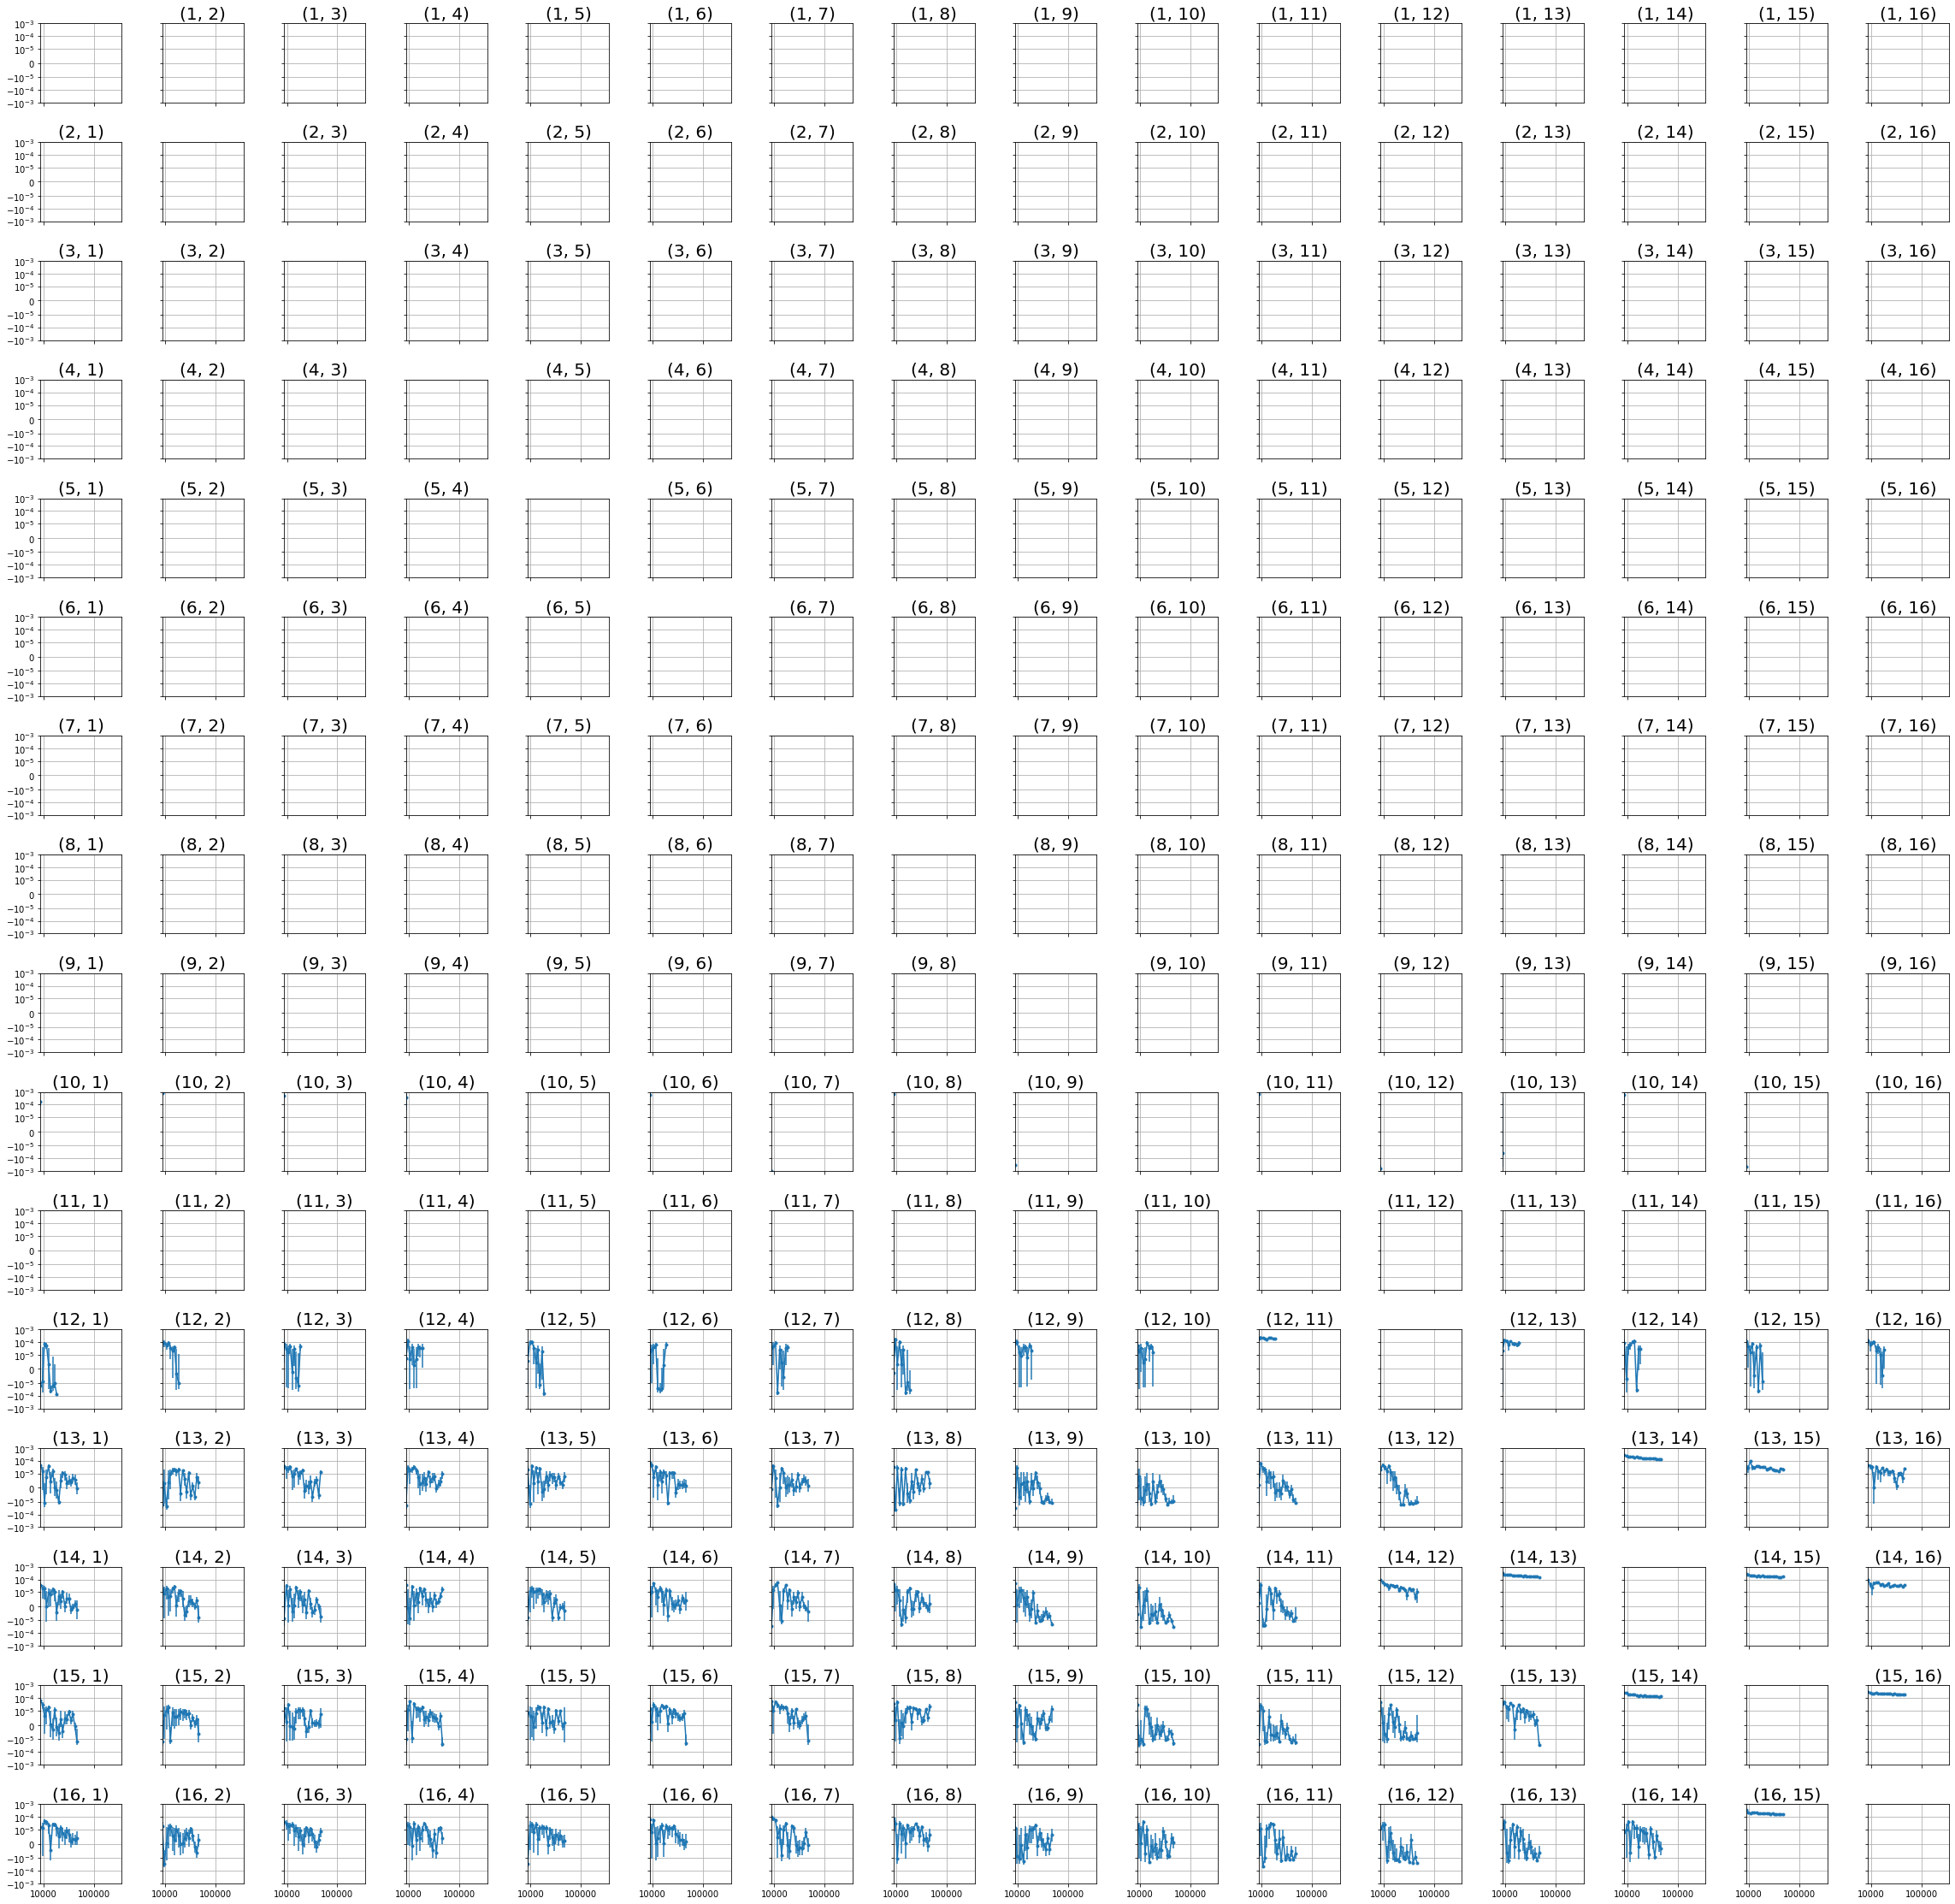

In [12]:
xmin0,xmax0=5e3,1.5e5
ymin0,ymax0=-1e-3,1e-3
linthreshy=1e-5

fig=plt.figure(figsize=(40,40))
axlist=[plt.subplot(16,16,i+1) for i in range(16**2)]
k=0
for i in range(16):
    for j in range(16):
        ax=axlist[k]
        ax.set_xlim([xmin0,xmax0]),ax.set_ylim(ymin0,ymax0)
        ax.set_yscale('symlog',linthresh=linthreshy)#,ax.set_xscale('log')
        ax.set_xticks([1e4,1e5])
        ax.grid()
        if i!=15: ax.set_xticklabels([])
        if j!=0: ax.set_yticklabels([])
        if i==j:
            k+=1
            continue
        ax.set_title(str((i+1,j+1)),fontsize=20)
        
        #f=ax.errorbar(xplot_as[i,j],yplot_as[i,j],yerr=yploterr_as[i,j],marker='.')
        #f=ax.errorbar(xplot_sp[i,j],yplot_sp[i,j],yerr=yploterr_sp[i,j],marker='.')
        xplot,yplot,yploterr=xplot_st[i,j],yplot_st[i,j],yploterr_st[i,j]
        gplot=np.where(~np.isnan(yplot))[0]
        if len(gplot)>0: ax.errorbar(xplot[gplot],yplot[gplot],yerr=yploterr[gplot],marker='.')
        k+=1
        
plt.subplots_adjust(hspace=.5,wspace=.5)

Text(0.5, 1.0, '(14, 13)')

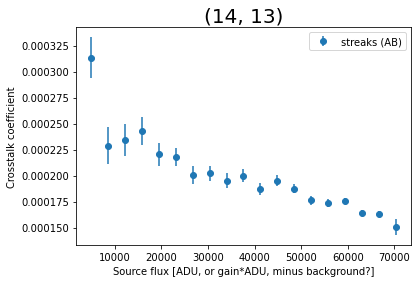

In [13]:
i,j=13,12#9,10#8,9#
plt.errorbar(xplot_st[i,j],yplot_st[i,j],yerr=yploterr_st[i,j],marker='o',ls='None',label='streaks (AB)')
plt.legend()
plt.xlabel('Source flux [ADU, or gain*ADU, minus background?]')
plt.ylabel('Crosstalk coefficient')
plt.title(str((i+1,j+1)),fontsize=20)
#plt.yscale('log')

In [21]:
srcdx=(xplot_st[i,j][1]-xplot_st[i,j][0])
print(srcdx,nxbins,srcdx*nxbins+minstreakpixval)

3625.0 40 150000.0


In [24]:
moscorr=mos.copy()
for i in range(16):
    for j in range(16):
        if i==j: continue
        srcvals,xtvals=xplot_st[i,j],yplot_st[i,j]
        for k in range(nxbins):
            srcval,xtval=srcvals[k],xtvals[k]
            gtarg=np.where((srcampvals_st==i) & (targampvals_st==j))
            gflux=np.where((srcvals_st[gtarg]-srcval>0) & (srcvals_st[gtarg]-srcval<srcdx))
            x,y=xposvals_st[gtarg][gflux].astype('int'),yposvals_st[gtarg][gflux].astype('int')
            moscorr[y,x]-=srcvals_st[gtarg][gflux]*xtval

-11.112102370268289 13.003820890988386 0.9458592603600479 0.8720119925451746 4.019320543542779


(0.9458592603600479,
 0.8720119925451746,
 4.019320543542779,
 <Figure size 1584x720 with 3 Axes>)

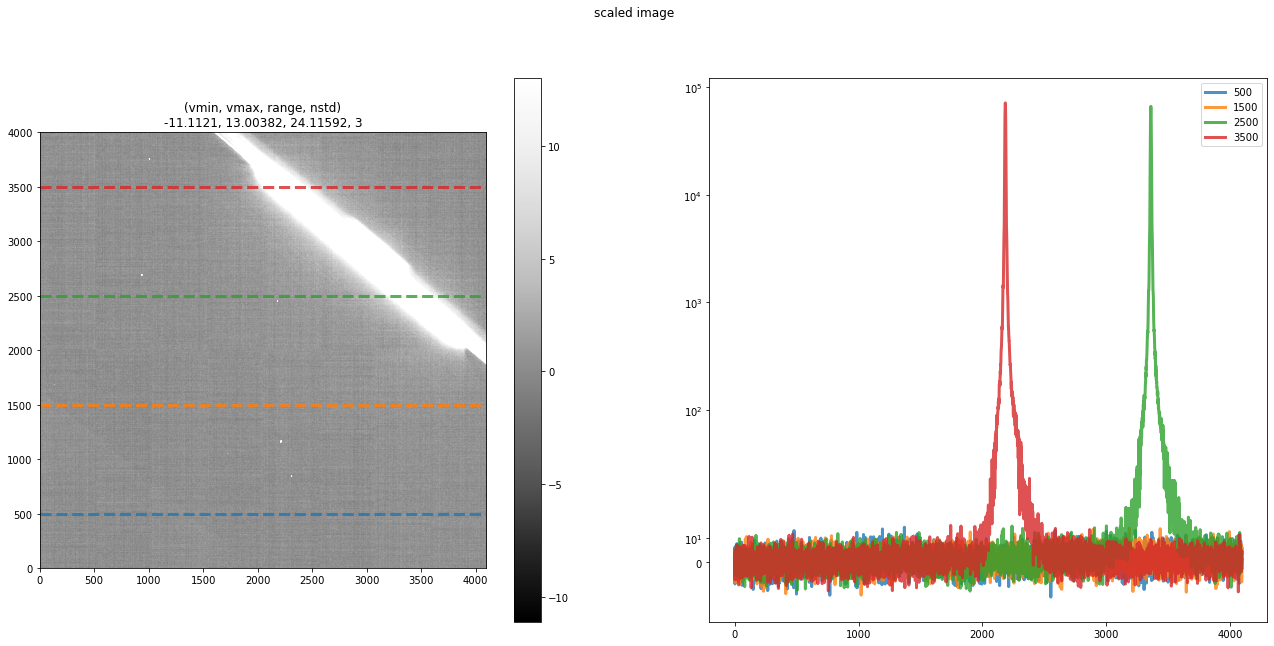

In [25]:
imshowdatclip(moscorr)

In [26]:
fits.writeto('moscorrmed50.fits',moscorr,overwrite=True)

-11.135893151740808 13.06299704640339 0.9635519473312911 0.8845042271020718 4.033148366357366


(0.9635519473312911,
 0.8845042271020718,
 4.033148366357366,
 <Figure size 1584x720 with 3 Axes>)

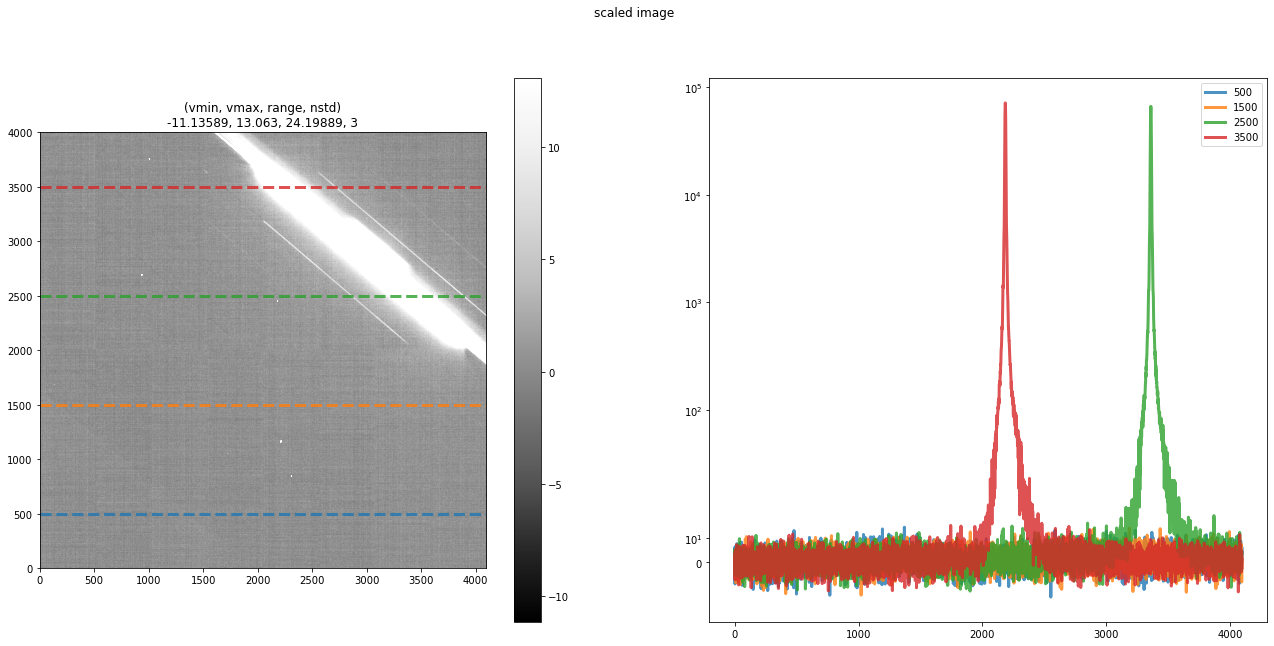

In [27]:
imshowdatclip(mos)

In [28]:
fits.writeto('mos.fits',mos,overwrite=True)

0.0 0.0 0.0 0.0 0.0


(0.0, 0.0, 0.0, <Figure size 1584x720 with 3 Axes>)

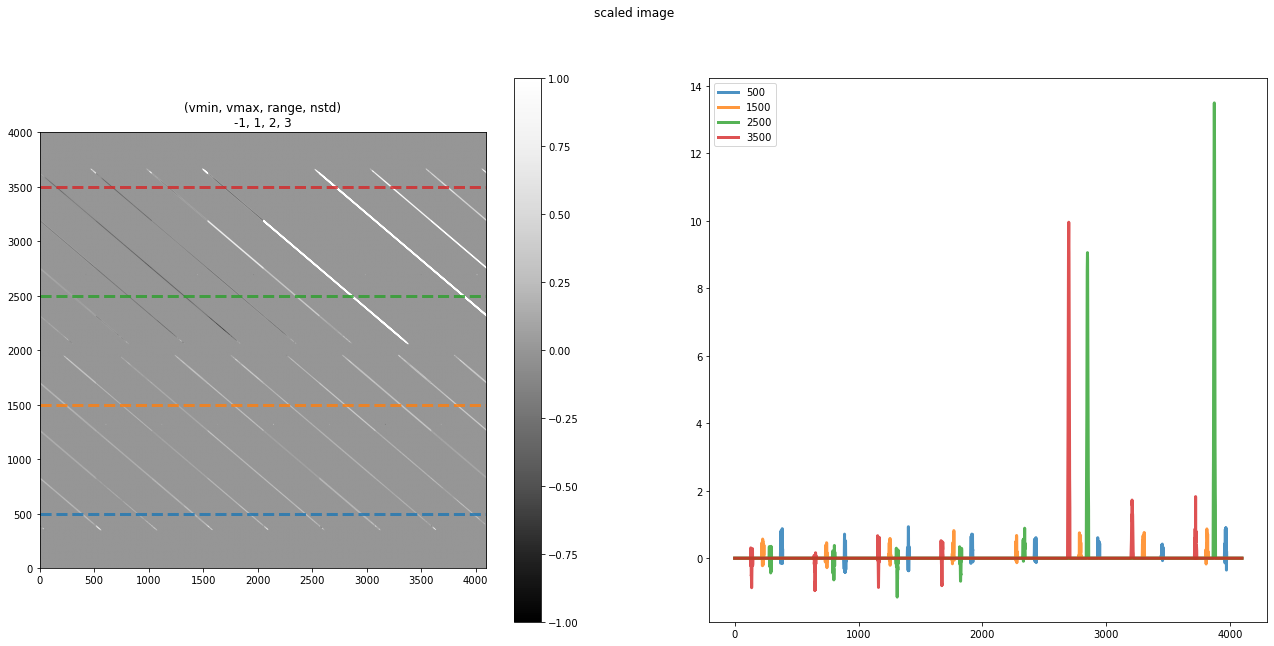

In [36]:
imshowdatclip(mos-moscorr,vminmaxim=(-1,1),lineplotsymlog=False)

In [31]:
fits.writeto('mosdiff.fits',mos-moscorr)

In [32]:
!ds9 mos.fits -scale zscale moscorrmed50.fits -scale zscale -frame lock image